In [1]:
import time
import numpy as np
from numba import typed
from pruning.timeseries import SignalConfig, TimeSeries
from pruning.base import SearchConfig
from pruning.periodogram import Periodogram
from pruning import utils, ffa, scores, simulate, kernels, math
from matplotlib import pyplot as plt

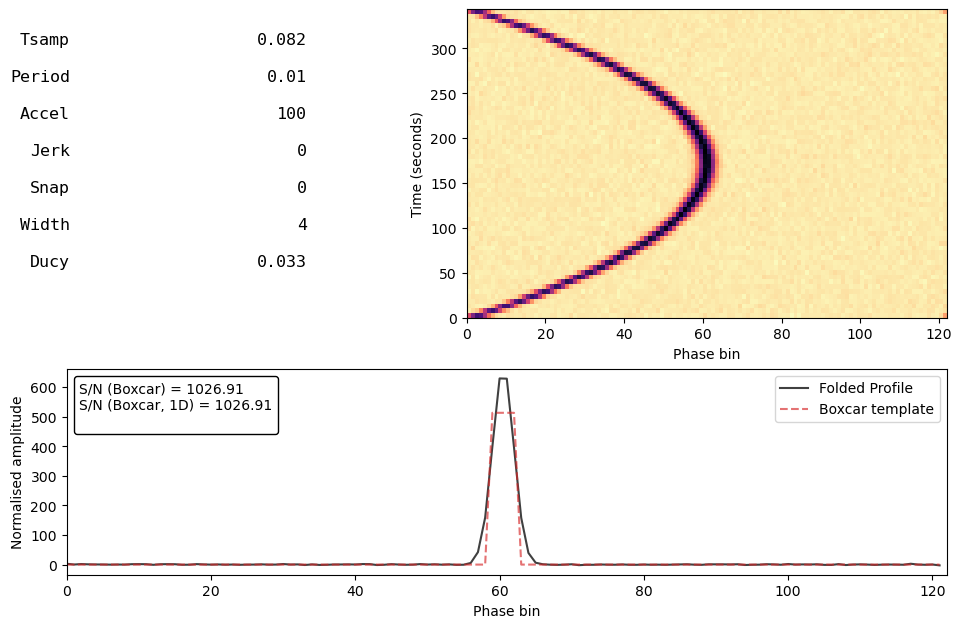

In [2]:
pulsar_period = 0.01
dt = 8.192e-5
accel = 100
nsamps = 2**22
mod_kwargs = {"acc": accel}

cfg = SignalConfig(period=pulsar_period, dt=dt, nsamps=nsamps, snr=1000, ducy=0.05, mod_kwargs=mod_kwargs)
tim_data = TimeSeries.generate_signal(cfg, shape="gaussian")
tim_data.plot_fold(cfg.freq, cfg.fold_bins, mod_kwargs=mod_kwargs); plt.show()

In [3]:
tol_bins = cfg.tol_bins
fold_bins = cfg.fold_bins_ideal

tol_bins = 2
param_limits = typed.List([(90.0, 110.0), (1/0.011, 1/0.009)])
search_cfg = SearchConfig(cfg.nsamps, cfg.dt, fold_bins, tol_bins, param_limits)
dyp = ffa.DynamicProgramming(tim_data, search_cfg)
dyp.initialize()
dyp.execute()

2024-07-28 09:09:02 INFO     - pruning.ffa - Initializing data structure...

2024-07-28 09:09:03 INFO     - pruning.ffa - param steps: [3.49004355e+06 5.02028105e-02]

2024-07-28 09:09:05 INFO     - pruning.ffa - fold dimensions: (1024, 1, 402, 2, 122)

                    INFO     - pruning.ffa - Initialization time: 2.597066879272461

                    INFO     - pruning.ffa - param steps: [8.72510887e+05 2.47601932e-02]

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


2024-07-28 09:09:07 INFO     - pruning.ffa - iteration: 1, fold dimensions: (512, 1, 815, 2, 122)

                    INFO     - pruning.ffa - param steps: [2.18127722e+05 1.22965212e-02]

                    INFO     - pruning.ffa - iteration: 2, fold dimensions: (256, 1, 1642, 2, 122)

                    INFO     - pruning.ffa - param steps: [5.45319304e+04 6.12757758e-03]

                    INFO     - pruning.ffa - iteration: 3, fold dimensions: (128, 1, 3296, 2, 122)

                    INFO     - pruning.ffa - param steps: [1.36329826e+04 3.05864409e-03]

                    INFO     - pruning.ffa - iteration: 4, fold dimensions: (64, 1, 6604, 2, 122)

                    INFO     - pruning.ffa - param steps: [3.40824565e+03 1.52803911e-03]

                    INFO     - pruning.ffa - iteration: 5, fold dimensions: (32, 1, 13220, 2, 122)

                    INFO     - pruning.ffa - param steps: [8.52061413e+02 7.63699222e-04]

                    INFO     - pruning.ffa - iteration: 6, fold dimensions: (16, 1, 26452, 2, 122)

                    INFO     - pruning.ffa - param steps: [2.13015353e+02 3.81769579e-04]

                    INFO     - pruning.ffa - iteration: 7, fold dimensions: (8, 1, 52916, 2, 122)

                    INFO     - pruning.ffa - param steps: [5.32538383e+01 1.90864788e-04]

2024-07-28 09:09:08 INFO     - pruning.ffa - iteration: 8, fold dimensions: (4, 1, 105844, 2, 122)

                    INFO     - pruning.ffa - param steps: [1.33134596e+01 9.54273941e-05]

                    INFO     - pruning.ffa - iteration: 9, fold dimensions: (2, 1, 211700, 2, 122)

                    INFO     - pruning.ffa - param steps: [3.32836489e+00 4.77124472e-05]

2024-07-28 09:09:13 INFO     - pruning.ffa - iteration: 10, fold dimensions: (1, 6, 423411, 2, 122)

In [4]:
folds = dyp.get_fold_norm()
widths = scores.generate_width_trials(dyp.nbins, ducy_max=0.2, wtsp=1.0)
snrs  = scores.boxcar_snr(folds, widths)
periods = dyp.param_arr[-1]
accels = dyp.param_arr[-2]

In [5]:
idx_per = math.find_nearest_sorted_idx(dyp.param_arr[-1], cfg.freq)
idx_acc = math.find_nearest_sorted_idx(dyp.param_arr[-2], cfg.mod_kwargs["acc"])
true_params_idx = (idx_acc, idx_per)

In [6]:
best_iaccel, best_iperiod, best_iwidth = np.unravel_index(np.nanargmax(snrs), snrs.shape)
print(np.unravel_index(np.nanargmax(snrs), snrs.shape))
print(f"Best acceleration = {accels[best_iaccel]}")
print(f"Best period = {1/periods[best_iperiod]}")
print(f"Best width = {widths[best_iwidth]}")
print(f"Best S/N = {np.nanmax(snrs)}")
print(f"expected width = {cfg.ducy * cfg.period / cfg.dt / cfg.fold_bins}")

(np.int64(2), np.int64(190522), np.int64(5))
Best acceleration = 98.57142857142857
Best period = 0.010000059163777263
Best width = 6
Best S/N = 830.384521484375
expected width = 0.050028816598360656


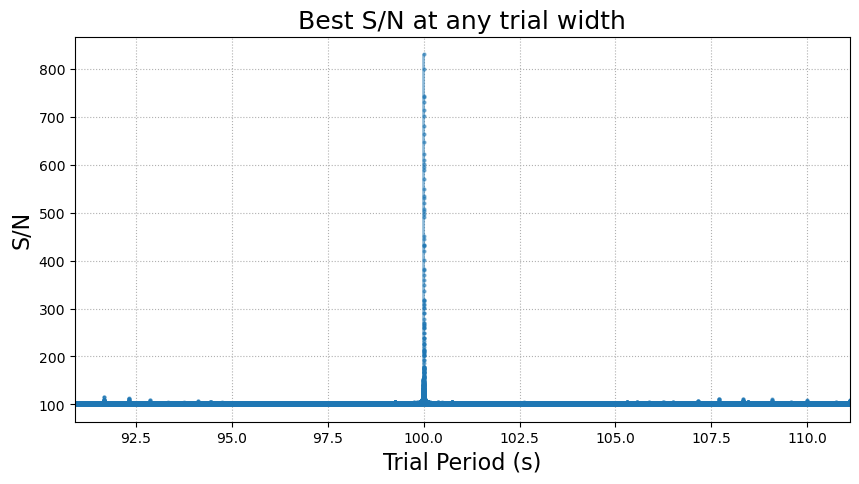

In [7]:
from pruning.periodogram import Periodogram
pgram = Periodogram(widths, periods, snrs[best_iaccel], tim_data.tobs)
pgram.plot(figsize=(10, 5)); plt.show()

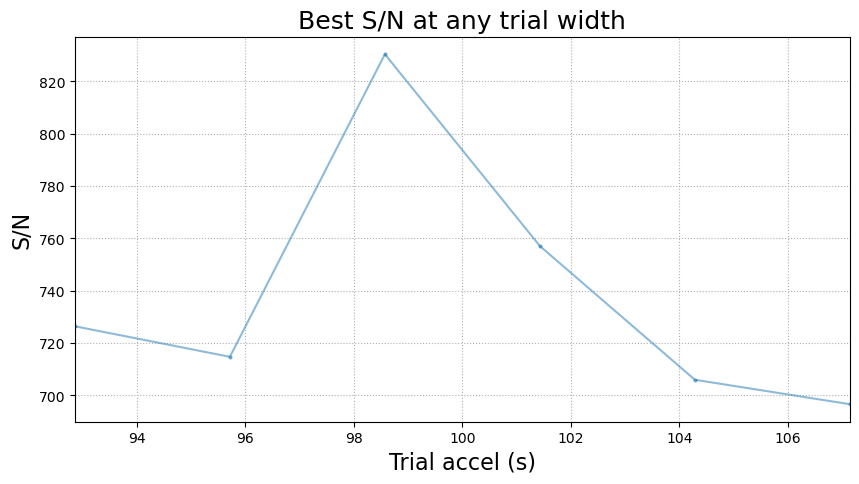

In [8]:
figure, ax = plt.subplots(figsize=(10, 5), dpi=100)
ax.plot(accels, snrs[:, best_iperiod].max(axis=1), marker="o", markersize=2, alpha=0.5)
ax.set_xlim(accels.min(), accels.max())
ax.set_xlabel("Trial accel (s)", fontsize=16)
ax.set_ylabel("S/N", fontsize=16)
plt.title("Best S/N at any trial width", fontsize=18)
ax.grid(linestyle=":")